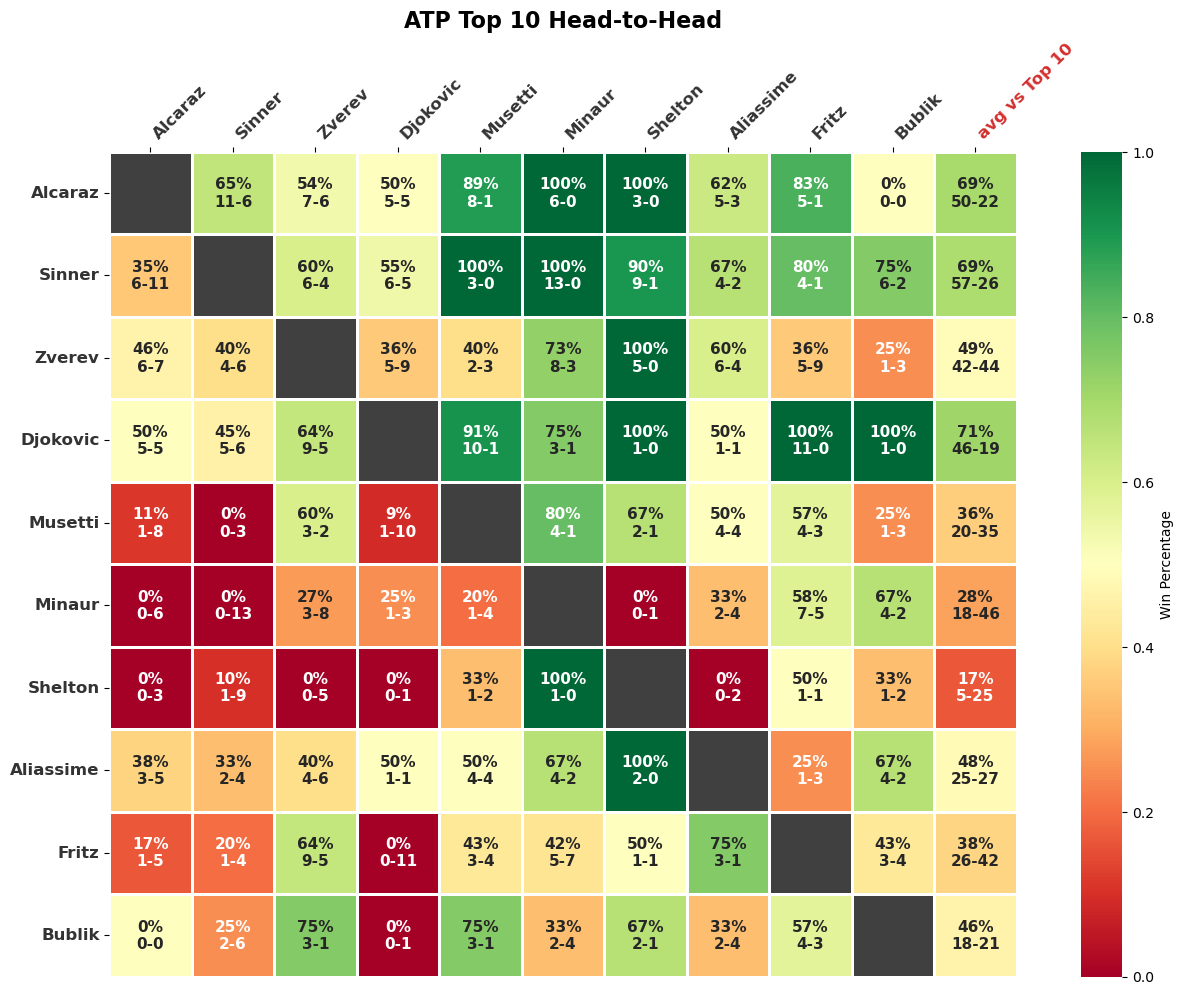

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import StringIO
import numpy as np

# 1. FETCH DATA
url = "https://tennisabstract.com/reports/h2hMatrix.html"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    html_data = StringIO(response.text)
    df = pd.read_html(html_data)[0]

    # --- DATA SLICING ---
    start_row = 0
    for i, row in df.iterrows():
        if "Alcaraz" in str(row.iloc[1]):
            start_row = i
            break
            
    # Slice 10 rows
    top_10 = df.iloc[start_row : start_row + 10, 1:12]
    top_10 = top_10.set_index(top_10.columns[0])
    top_10.columns = top_10.index

    # Shorten names
    short_names = [name.split()[-1] for name in top_10.index]
    top_10.index = short_names
    top_10.columns = short_names

    # --- CALCULATE TOTALS ---
    # We need to calculate the "Total vs Top 10" for each player before building the matrix
    total_stats = []
    
    for player in top_10.index:
        total_wins = 0
        total_losses = 0
        
        for opponent in top_10.columns:
            if player == opponent: continue
            
            record = str(top_10.loc[player, opponent])
            if "-" in record:
                w, l = map(int, record.split('-'))
                total_wins += w
                total_losses += l
        
        total_games = total_wins + total_losses
        win_pct = total_wins / total_games if total_games > 0 else 0
        total_stats.append({'pct': win_pct, 'wins': total_wins, 'losses': total_losses})

    # --- MATRIX PREPARATION (Add Extra Column) ---
    # We add 1 extra column for the total
    cols_with_total = list(top_10.columns) + ["avg vs Top 10"]
    
    color_matrix = pd.DataFrame(index=top_10.index, columns=cols_with_total, dtype=float)
    label_matrix = pd.DataFrame(index=top_10.index, columns=cols_with_total, dtype=object)
    mask = pd.DataFrame(False, index=top_10.index, columns=cols_with_total)

    for p1 in top_10.index:
        # 1. FILL REGULAR CELLS
        for p2 in top_10.columns:
            if p1 == p2:
                mask.loc[p1, p2] = True
                continue

            record = str(top_10.loc[p1, p2])
            try:
                if "-" in record:
                    wins, losses = map(int, record.split('-'))
                    total = wins + losses
                    if total > 0:
                        pct = wins / total
                        color_matrix.loc[p1, p2] = pct
                        label_matrix.loc[p1, p2] = f"{pct:.0%}\n{wins}-{losses}"
                    else:
                        color_matrix.loc[p1, p2] = 0.5
                        label_matrix.loc[p1, p2] = "0%\n0-0"
                else:
                    color_matrix.loc[p1, p2] = 0.5
                    label_matrix.loc[p1, p2] = ""
            except:
                color_matrix.loc[p1, p2] = 0.5
        
        # 2. FILL THE "TOTAL" COLUMN
        stats = total_stats[list(top_10.index).index(p1)]
        color_matrix.loc[p1, "avg vs Top 10"] = stats['pct']
        label_matrix.loc[p1, "avg vs Top 10"] = f"{stats['pct']:.0%}\n{stats['wins']}-{stats['losses']}"

    # --- VISUALIZATION ---
    plt.figure(figsize=(14, 10))
    plt.rcParams['axes.facecolor'] = '#404040' 
    
    ax = sns.heatmap(
        color_matrix, 
        annot=label_matrix, 
        fmt="", 
        cmap="RdYlGn", 
        center=0.5,
        mask=mask, 
        linewidths=2, 
        linecolor='white',
        cbar_kws={'label': 'Win Percentage'},
        square=True, # Note: The "Total" column might look slightly rectangular if aspect ratio forces it
        annot_kws={"size": 11, "weight": "bold"}
    )

    # Style Axis
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Rotate labels
    plt.xticks(rotation=45, ha='left', fontsize=12, fontweight='bold', color='#333333')
    plt.yticks(rotation=0, fontsize=12, fontweight='bold', color='#333333')
    
    # Make the "vs Top 10" label stand out (Optional Red Color)
    xtick_labels = ax.get_xticklabels()
    xtick_labels[-1].set_color("#D32F2F") # Dark Red for the Total Column Header
    ax.set_xticklabels(xtick_labels)

    plt.title("ATP Top 10 Head-to-Head", fontsize=16, pad=30, fontweight='bold', y=1.1)
    plt.xlabel("") 
    plt.ylabel("")
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")